<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/100_World_Models_Model_Based_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 World Models: Maszyny, które śnią

Model-Free RL (DQN) to "odruch". Widzę -> Reaguję.
Model-Based RL (World Models) to "wyobraźnia". Widzę -> Przewiduję przyszłość -> Planuję -> Reaguję.

Architektura składa się z 3 części:
1.  **V (Vision - VAE):** Zmienia obraz z kamery (np. 64x64 piksele) na mały wektor stanu $z$ (np. 32 liczby). (To robiliśmy w notatniku 43).
2.  **M (Memory - MDN-RNN):** To jest **Model Świata**. Bierze obecny stan $z_t$ i akcję $a_t$, i przewiduje przyszły stan $z_{t+1}$.
    *   To sieć rekurencyjna, która "umie fizykę".
3.  **C (Controller):** Prosta sieć liniowa, która decyduje o ruchu, patrząc na wizję ($z$) i pamięć ($h$).

W tym notatniku zbudujemy "Silnik Snów" (komponent M).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_SIZE = 32  # Rozmiar skompresowanego świata (z)
ACTION_SIZE = 1   # Jedna akcja (np. skręć kierownicą)
HIDDEN_SIZE = 256 # Pamięć RNN

print(f"Budujemy symulator świata na: {DEVICE}")

Budujemy symulator świata na: cuda


## 1. Komponent M (Memory / World Model)

To jest serce systemu.
Jest to sieć **LSTM**, która działa jako predyktor.

Wejście:
*   Aktualny stan świata ($z_t$) - skompresowany przez VAE.
*   Akcja, którą podjął agent ($a_t$).

Wyjście:
*   Przewidywany następny stan świata ($z_{t+1}$).
*   (W pełnej wersji przewiduje rozkład prawdopodobieństwa Gaussian Mixture, tu dla uproszczenia przewidzimy średnią).

Dzięki temu model może "odtworzyć" film z gry w swojej głowie, nie dotykając klawiatury.

In [2]:
class WorldModel(nn.Module):
    def __init__(self):
        super().__init__()
        # LSTM przyjmuje: Stan Latentny + Akcję
        self.lstm = nn.LSTM(input_size = LATENT_SIZE + ACTION_SIZE, 
                            hidden_size = HIDDEN_SIZE, 
                            batch_first = True)
        
        # Głowica przewidująca następny stan (Z_next)
        self.predict_next_z = nn.Linear(HIDDEN_SIZE, LATENT_SIZE)

    def forward(self, z, action, hidden_state=None):
        # z: [Batch, Seq, 32]
        # action: [Batch, Seq, 1]
        
        # Łączymy stan i akcję (Input Fusion)
        x = torch.cat([z, action], dim=-1) # [Batch, Seq, 33]
        
        # Pamięć przetwarza sytuację
        lstm_out, new_hidden = self.lstm(x, hidden_state)
        
        # Przewidujemy, co się stanie
        next_z = self.predict_next_z(lstm_out)
        
        return next_z, new_hidden

model_m = WorldModel().to(DEVICE)
print("Model Świata gotowy (Symulator Fizyki).")

Model Świata gotowy (Symulator Fizyki).


## 2. Symulacja "Snu" (Dreaming)

Wyobraź sobie, że Agent jedzie samochodem (w grze).
Nagle **odcinamy mu kamerę**.
Agent musi "zamknąć oczy" i jechać dalej, polegając tylko na swoich przewidywaniach.

Zrobimy pętlę, w której wyjście modelu ($z_{t+1}$) staje się wejściem w następnym kroku.
To jest **Halucynacja**.

In [3]:
def dream_trajectory(model, steps=50):
    model.eval()
    
    # 1. Stan początkowy (Losowy punkt w świecie)
    # W prawdziwym życiu to byłby obraz z kamery przepuszczony przez VAE
    current_z = torch.randn(1, 1, LATENT_SIZE).to(DEVICE)
    
    # Inicjalizacja pamięci LSTM
    hidden = None
    
    trajectory = []
    
    with torch.no_grad():
        for t in range(steps):
            # Agent wykonuje akcję (np. ciągle skręca w prawo = 1.0)
            # W pełnym modelu akcję wybierałby Komponent C (Controller)
            action = torch.tensor([[[1.0]]]).to(DEVICE) 
            
            # Pytamy Model Świata: "Co się stanie, jak skręcę w prawo?"
            next_z, hidden = model(current_z, action, hidden)
            
            # Zapisujemy "wyobrażenie"
            trajectory.append(next_z.cpu().numpy().flatten())
            
            # To co sobie wyobraziliśmy, staje się naszą nową rzeczywistością
            # (Odcięcie od prawdziwych sensorów!)
            current_z = next_z
            
    return np.array(trajectory)

# Uruchamiamy sen
dream_data = dream_trajectory(model_m)
print(f"Wygenerowano sen o długości {len(dream_data)} kroków.")

Wygenerowano sen o długości 50 kroków.


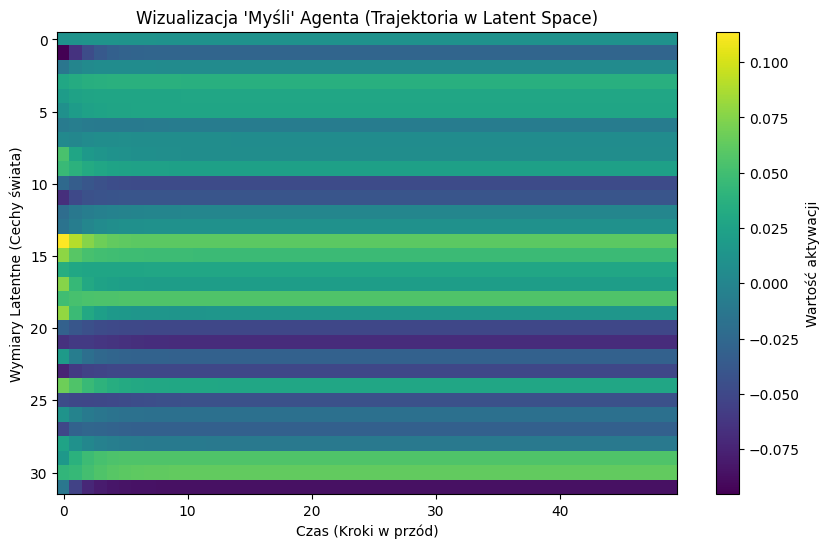

In [4]:
# WIZUALIZACJA SNU
# Ponieważ Z ma 32 wymiary, pokażemy to jako mapę ciepła
# Oś X: Wymiary latentne (cechy świata)
# Oś Y: Czas (przyszłość)

plt.figure(figsize=(10, 6))
plt.imshow(dream_data.T, aspect='auto', cmap='viridis')
plt.colorbar(label="Wartość aktywacji")
plt.title("Wizualizacja 'Myśli' Agenta (Trajektoria w Latent Space)")
plt.xlabel("Czas (Kroki w przód)")
plt.ylabel("Wymiary Latentne (Cechy świata)")
plt.show()

## 🧠 Podsumowanie: Trening we Śnie

Co widzisz na wykresie?
To są **zmieniające się stany gry**, które wygenerował model.
*   Jeśli model jest niewytrenowany (jak teraz) -> Widzisz losowy szum lub proste wzory.
*   Jeśli model jest wytrenowany (np. na grze CarRacing) -> Widziałbyś, jak parametry odpowiadające za "zakręt" powoli się zmieniają, symulując ruch samochodu.

**Dlaczego to jest SOTA?**
Wytrenowanie modelu świata na milionach filmów z YouTube (jak robi to model **Sora** od OpenAI lub **Gen-2** od Runway) pozwala komputerowi zrozumieć fizykę.
Gdy AI rozumie fizykę, może planować działania w świecie rzeczywistym, nie robiąc sobie krzywdy.

**Model-Based RL** to przyszłość robotyki.